D606 - Data Science Capstone  
EBN2 — EBN2 Task 2: Data Analysis Report  
Logistic Regression Analysis of Adolescent Suicidal Ideation  
John D. Pickering

In [1]:
# Import Dependencies

import pandas as pd
from pathlib import Path
import re
import fitz  # PyMuPDF
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


### Data Import
- Import Exported .csv files from 2009-2023
- Conver multi-point answers to binary
- Data Files
    - yrbs2009.csv
    - yrbs2011.csv
    - yrbs2013.csv
    - yrbs2015.csv
    - yrbs2017.csv
    - yrbs2019.csv
    - yrbs2021.csv
    - yrbs2023.csv
- Support Files
    - variable_mapping.csv
    - IndenpendentVariables.xlsx
    - 02_Age.csv
    - 04_Grade.csv
    - 05_Race.csv
    - 09_30_Days_Unsafe_At_School.csv
    - 10_Threatened_School_Weapon.csv
    - 11_Physically_Hurt_BF_GF.csv
    - 17_Attempt_Suicide.csv

In [ ]:
# Load Mapping File - Used to determine which data should be improted from the 8 seperate YSBR Data Files
mapping = pd.read_csv(MAPPING_FILE)
mapping.columns = mapping.columns.str.strip().str.lower()
mapping.columns = [col.strip() for col in mapping.columns]

# Load Indenpendent Variable List
iv = pd.read_excel("IndenpendentVariables.xlsx")

# Clean column names
iv.columns = iv.columns.str.strip()
# Filter to ONLY rows where Type == "Binary"

In [2]:
DATA_FOLDER = "."          # folder with your yrbsYYYY.csv files
MAPPING_FILE = "variable_mappings.csv"

# -----------------------------
# Load mapping table
# -----------------------------
mapping = pd.read_csv(MAPPING_FILE)
mapping.columns = mapping.columns.str.strip().str.lower()
mapping.columns = [col.strip() for col in mapping.columns]

# Ensure first column is YEAR
if mapping.columns[0].lower() != "year":
    mapping.rename(columns={mapping.columns[0]: "year"}, inplace=True)

mapping["year"] = mapping["year"].astype(int)

combined = []

# -----------------------------
# Process each year
# -----------------------------
for idx, row in mapping.iterrows():
    year = row["year"]
    csv_file = f"yrbs{year}.csv"
    csv_path = os.path.join(DATA_FOLDER, csv_file)

    print(f"\n📥 Loading {csv_file}")

    if not os.path.exists(csv_path):
        print(f"Missing file: {csv_path}")
        continue

    # Load the CSV, lowercasing all column names
    df = pd.read_csv(csv_path, low_memory=False)
    df.columns = df.columns.str.lower()

    # Build rename dictionary from mapping
    rename_dict = {}
    for col in mapping.columns:
        if col == "year":
            continue

        raw_name = row[col]

        # Skip variables not present in this year
        if pd.isna(raw_name):
            continue

        source_col = str(raw_name).strip().lower()

        if source_col in df.columns:
            rename_dict[source_col] = col
        else:
            print(f"⚠ Missing: {source_col} in {csv_file}")

    # Keep only mapped columns and rename to standard names
    cols_we_keep = list(rename_dict.keys())
    df = df[cols_we_keep].rename(columns=rename_dict)

    # Add YEAR column
    df["YEAR"] = year

    # --------------------------------------------------
    # FIX 2009–2011 variation in 11_physically_hurt_bf_gf
    # --------------------------------------------------
    if "11_physically_hurt_bf_gf" in df.columns:

        if year <= 2011:
            # Convert old binary:
            # 1 = Yes  → 3 (1 time)
            # 2 = No   → 2 (0 times)
            df["11_physically_hurt_bf_gf"] = df["11_physically_hurt_bf_gf"].apply(
                lambda x: 3 if x == 1 else (2 if x == 2 else None)
            )
        # For 2013+, keep the original 1–6 scale exactly as is

    # Append cleaned year
    combined.append(df)

# -----------------------------
# Combine all years
# -----------------------------
if combined:
    final_df = pd.concat(combined, ignore_index=True)
    final_df.columns = final_df.columns.str.strip().str.lower()
    print("\nFinal dataset shape:", final_df.shape)

    final_df.to_csv("YRBS_Combined_2009_2023.csv", index=False)
    print("Saved as: YRBS_Combined_2009_2023.csv")
else:
    print("No valid datasets loaded.")


📥 Loading yrbs2009.csv

📥 Loading yrbs2011.csv

📥 Loading yrbs2013.csv

📥 Loading yrbs2015.csv

📥 Loading yrbs2017.csv

📥 Loading yrbs2019.csv

📥 Loading yrbs2021.csv

📥 Loading yrbs2023.csv

Final dataset shape: (126819, 25)
Saved as: YRBS_Combined_2009_2023.csv


In [3]:
# Check column information post import.  
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126819 entries, 0 to 126818
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   02_age                          126195 non-null  float64
 1   03_sex                          125863 non-null  float64
 2   04_grade                        125883 non-null  float64
 3   05_race                         124817 non-null  float64
 4   06_ethnicity                    123950 non-null  float64
 5   09_30_days_unsafe_at_school     122672 non-null  float64
 6   10_threatened_school_weapon     123158 non-null  float64
 7   11_physically_hurt_bf_gf        122977 non-null  float64
 8   12_bullied_at_school_12_months  123952 non-null  float64
 9   13_forced_sexual_intercourse    116476 non-null  float64
 10  14_sad_hopeless                 125223 non-null  float64
 11  15_consider_suicide             125022 non-null  float64
 12  16_plan_suicide 

In [4]:

binary_fields = (
    iv[iv["Type"].str.strip().str.lower() == "binary"]["Field"]
    .astype(str)
    .str.strip()
    .tolist()
)

print("Binary Variables to Convert:")
print(binary_fields)

# Function to convert 1 → 1 and 2 → 0
def convert_to_binary(series):
    return series.apply(lambda x: 1 if x == 1 else (0 if x == 2 else None))

# Apply conversion ONLY to columns in binary_fields
for col in binary_fields:
    if col in final_df.columns:

        # Convert float → Int64 so comparisons work correctly
        final_df[col] = final_df[col].astype("Int64")

        # Apply binary conversion
        final_df[col] = convert_to_binary(final_df[col])

    else:
        print(f"⚠ Warning: Column '{col}' listed as Binary but not found in df.")

Binary Variables to Convert:
['12_bullied_at_school_12_months', '13_forced_sexual_intercourse', '14_sad_hopeless', '15_consider_suicide', '16_plan_suicide']


#### Explanation of Binary Field Conversion
This block of code standardizes all variables that are defined as binary in the IndependentVariables.xlsx file. The spreadsheet includes a Type column that allows us to explicitly mark which fields must be treated as binary, giving us full control over the variables used in modeling.  

This filters the metadata table so that only fields with Type = "Binary" are selected.
This approach ensures that the conversion process affects only the intended variables, preventing accidental modification of demographic or multi-category fields.

Many YRBS “binary” variables are not recorded as 0/1.
Instead, they use:
- 1 = Yes
- 2 = No
- Other values or missing = skipped / not answered  

Machine-learning algorithms require consistent 0/1 binary inputs, so this function converts the YRBS coding into a standard binary format.  
- 1 → 1
- 2 → 0
- Anything else → NaN

In [5]:
# Create lowercase column names
for col in final_df.columns:
    if final_df[col].dtype == "float64":
        final_df[col] = final_df[col].astype("Int64")

In [6]:
import pandas as pd
import numpy as np
import os

LOOKUP_DIR = "."

# ----------------------------------------------------------
# Load lookup table for a variable (must be valid CSV)
# ----------------------------------------------------------
def load_lookup(var_name):
    lookup_path = os.path.join(LOOKUP_DIR, f"{var_name}.csv")

    # If there is no CSV file, do NOT attempt to load anything
    if not os.path.isfile(lookup_path):
        return None

    # Try UTF-8 first, fallback to latin-1
    try:
        return pd.read_csv(lookup_path, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(lookup_path, encoding="latin-1")
    except Exception:
        return None


# ----------------------------------------------------------
# Determine if variable should be binary converted
# ----------------------------------------------------------
def is_multi_answer(lookup_df):
    if lookup_df is None:
        return False

    # Missing codes
    missing_codes = {7, 8, 9, 97, 98, 99}

    if "Answer" not in lookup_df.columns:
        return False

    valid = lookup_df[~lookup_df["Answer"].isin(missing_codes)]

    return valid["Answer"].nunique() > 1


# ----------------------------------------------------------
# Convert numeric values to binary
# ----------------------------------------------------------
def convert_to_binary(series):
    s = pd.to_numeric(series, errors="coerce")

    missing_codes = {7, 8, 9, 97, 98, 99}
    out = pd.Series(pd.NA, index=s.index, dtype="Int64")

    out[s == 1] = 0
    out[s >= 2] = 1
    out[s.isna() | s.isin(missing_codes)] = pd.NA
    return out


# ----------------------------------------------------------
# Variables that should NEVER be binary converted
# ----------------------------------------------------------
demographic_vars = {
    "02_age",
    "03_sex",
    "04_grade",
    "05_race",
    "06_ethnicity"
}

# ----------------------------------------------------------
# APPLY BINARY CONVERSION
# ----------------------------------------------------------
binary_count = 0

for var in final_df.columns:

    if var.endswith("_label"):
        continue

    if var.lower() in demographic_vars:
        continue

    lookup_df = load_lookup(var)

    if lookup_df is not None and is_multi_answer(lookup_df):
        new_col = f"{var}_binary"
        print(f"Converting {var} → {new_col}")
        final_df[new_col] = convert_to_binary(final_df[var])
        binary_count += 1

print(f"\n✔ Completed binary conversion for {binary_count} variables.")


Converting 09_30_days_unsafe_at_school → 09_30_days_unsafe_at_school_binary
Converting 10_threatened_school_weapon → 10_threatened_school_weapon_binary
Converting 11_physically_hurt_bf_gf → 11_physically_hurt_bf_gf_binary
Converting 17_attempt_suicide → 17_attempt_suicide_binary
Converting 20_marijuana_lifetime → 20_marijuana_lifetime_binary
Converting 21_cocaine_lifetime → 21_cocaine_lifetime_binary
Converting 22_heroin_lifetime → 22_heroin_lifetime_binary
Converting 23_methamphetamines_lifetime → 23_methamphetamines_lifetime_binary
Converting 24_mdma_lifetime → 24_mdma_lifetime_binary
Converting 28_hallucinogenic drugs → 28_hallucinogenic drugs_binary
Converting 32_physical_fight_school → 32_physical_fight_school_binary
Converting 34_more_than_5_drinks_30_days → 34_more_than_5_drinks_30_days_binary
Converting 38_5_drinks_30_days_boy_girl → 38_5_drinks_30_days_boy_girl_binary

✔ Completed binary conversion for 13 variables.


#### Explanation of Automated Binary Conversion Using Lookup Tables
This code automates the conversion of multi-answer YRBS variables into standardized binary fields. For each variable in the dataset, the code attempts to load a corresponding lookup table that describes the answer options for the questions. If a lookup file is available and the variable contains more than one valid answer category, it is considered a multi-answer behavioral variable. In this case, the variable will be simplified into a binary format with 0s and 1s.

This binary format indicates whether a behavior has ever occurred, which is the standard method for preparing Youth Risk Behavior Surveillance (YRBS) risk-behavior data for statistical modeling. The code omits demographic and label fields from this process, as those variables need to stay in their original categorical format.

For each eligible variable, the numeric values are converted as follows: "never" is assigned a value of 0, any occurrence of the event is assigned a value of 1, and missing or invalid codes are represented as NA. A new binary column is created for each transformed variable. This metadata-driven approach ensures that the binary conversions are consistent, transparent, and easy to maintain. To process a new variable automatically, you simply need to add a lookup file.

In [7]:
# Standardize field names to lowercase.
final_df.columns = final_df.columns.str.strip().str.lower()

In [9]:
# Save file for later use. 
final_df.to_csv("YRBS_Combined_2009_2023_Cleaned.csv", index=False)

#### Data Cleanup

In [10]:
df = final_df.copy()
# Standardize column names
df.columns = (
    df.columns
    .str.strip()                 # remove leading/trailing spaces
    .str.replace(" ", "_")       # replace spaces with underscores
    .str.replace("-", "_")       # replace hyphens with underscores
    .str.replace("/", "_")       # replace slashes
    .str.replace(r"[^A-Za-z0-9_]", "", regex=True)  # remove special chars
    .str.replace("__+", "_", regex=True)            # collapse multiple underscores
)

# Make sure everything is lowercase OR keep original casing?

final_df.columns = df.columns.str.lower()

# 3. Save cleaned dataset
final_df.to_csv("YRBS_Combined_2009_2023_Cleaned.csv", index=False)

print("✔Column cleanup complete!")
print("New column sample:")
print(df.columns[:20])

✔ Column cleanup complete!
New column sample:
Index(['02_age', '03_sex', '04_grade', '05_race', '06_ethnicity',
       '09_30_days_unsafe_at_school', '10_threatened_school_weapon',
       '11_physically_hurt_bf_gf', '12_bullied_at_school_12_months',
       '13_forced_sexual_intercourse', '14_sad_hopeless',
       '15_consider_suicide', '16_plan_suicide', '17_attempt_suicide',
       '20_marijuana_lifetime', '21_cocaine_lifetime', '22_heroin_lifetime',
       '23_methamphetamines_lifetime', '24_mdma_lifetime',
       '25_sexual_intercouse'],
      dtype='object')


#### Column Standardization

This section standardizes all column names in the dataset to ensure they are clean, consistent, and safe for use throughout the analysis pipeline. The original column names contained spaces, hyphens, slashes, and other special characters that could cause issues when selecting columns, joining tables, or running statistical models. 

To address this, the code begins by creating a working copy of the dataset and applies a series of string transformations to the column names. These transformations include removing excess whitespace, replacing spaces and punctuation with underscores, stripping special characters, and collapsing multiple underscores into a single one. 

After cleaning up the structure, all column names are converted to lowercase to maintain a uniform naming convention. This makes it easier to reference fields without concerns about capitalization. Finally, the cleaned dataset is saved as a new CSV file, and a sample of the updated column names is printed to confirm that the standardization was successful.


In [12]:
# Ensure YEAR column is numeric
year_col = "year" if "year" in df.columns else "YEAR"
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")

###### Data Demographics

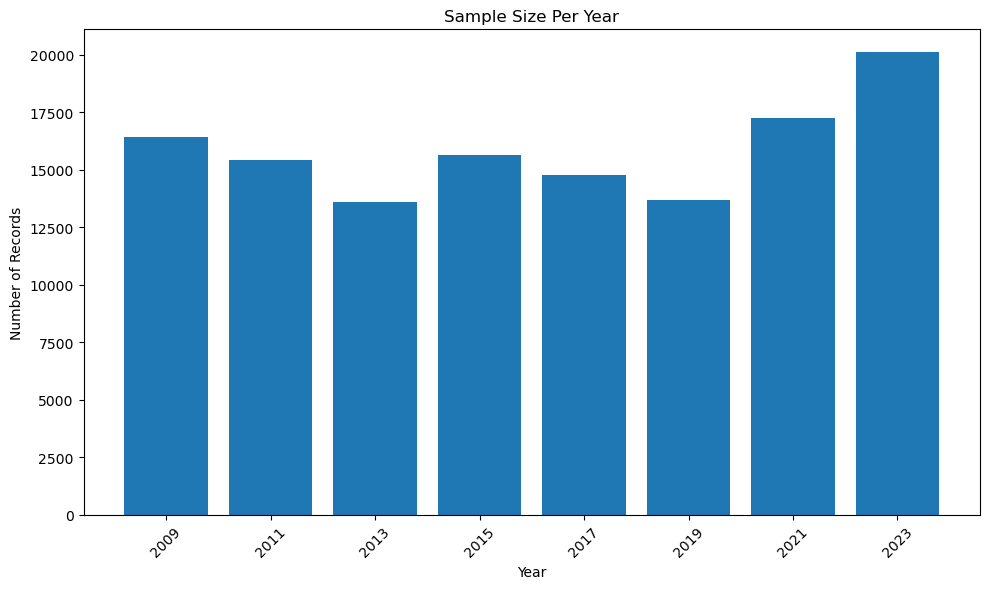

In [13]:
# ============================================================
# Show data counts by year.
# ============================================================
plt.figure(figsize=(10, 6))
year_counts = df[year_col].value_counts().sort_index()
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.title("Data Count by year")
plt.xlabel("Year")
plt.ylabel("Number of Records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This chart shows the number of survey responses collected in each YRBS cycle from 2009 through 2023. The sample size varies from year to year, which is expected because each administration of the survey involves different participating schools and response rates. Despite these fluctuations, each year still provides a large enough sample—typically between 13,000 and 20,000 records—to support reliable descriptive analysis and statistical modeling across the study period.

/tmp/ipykernel_29952/4209794548.py:86: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jdpic/miniconda3/envs/shap_env_new/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


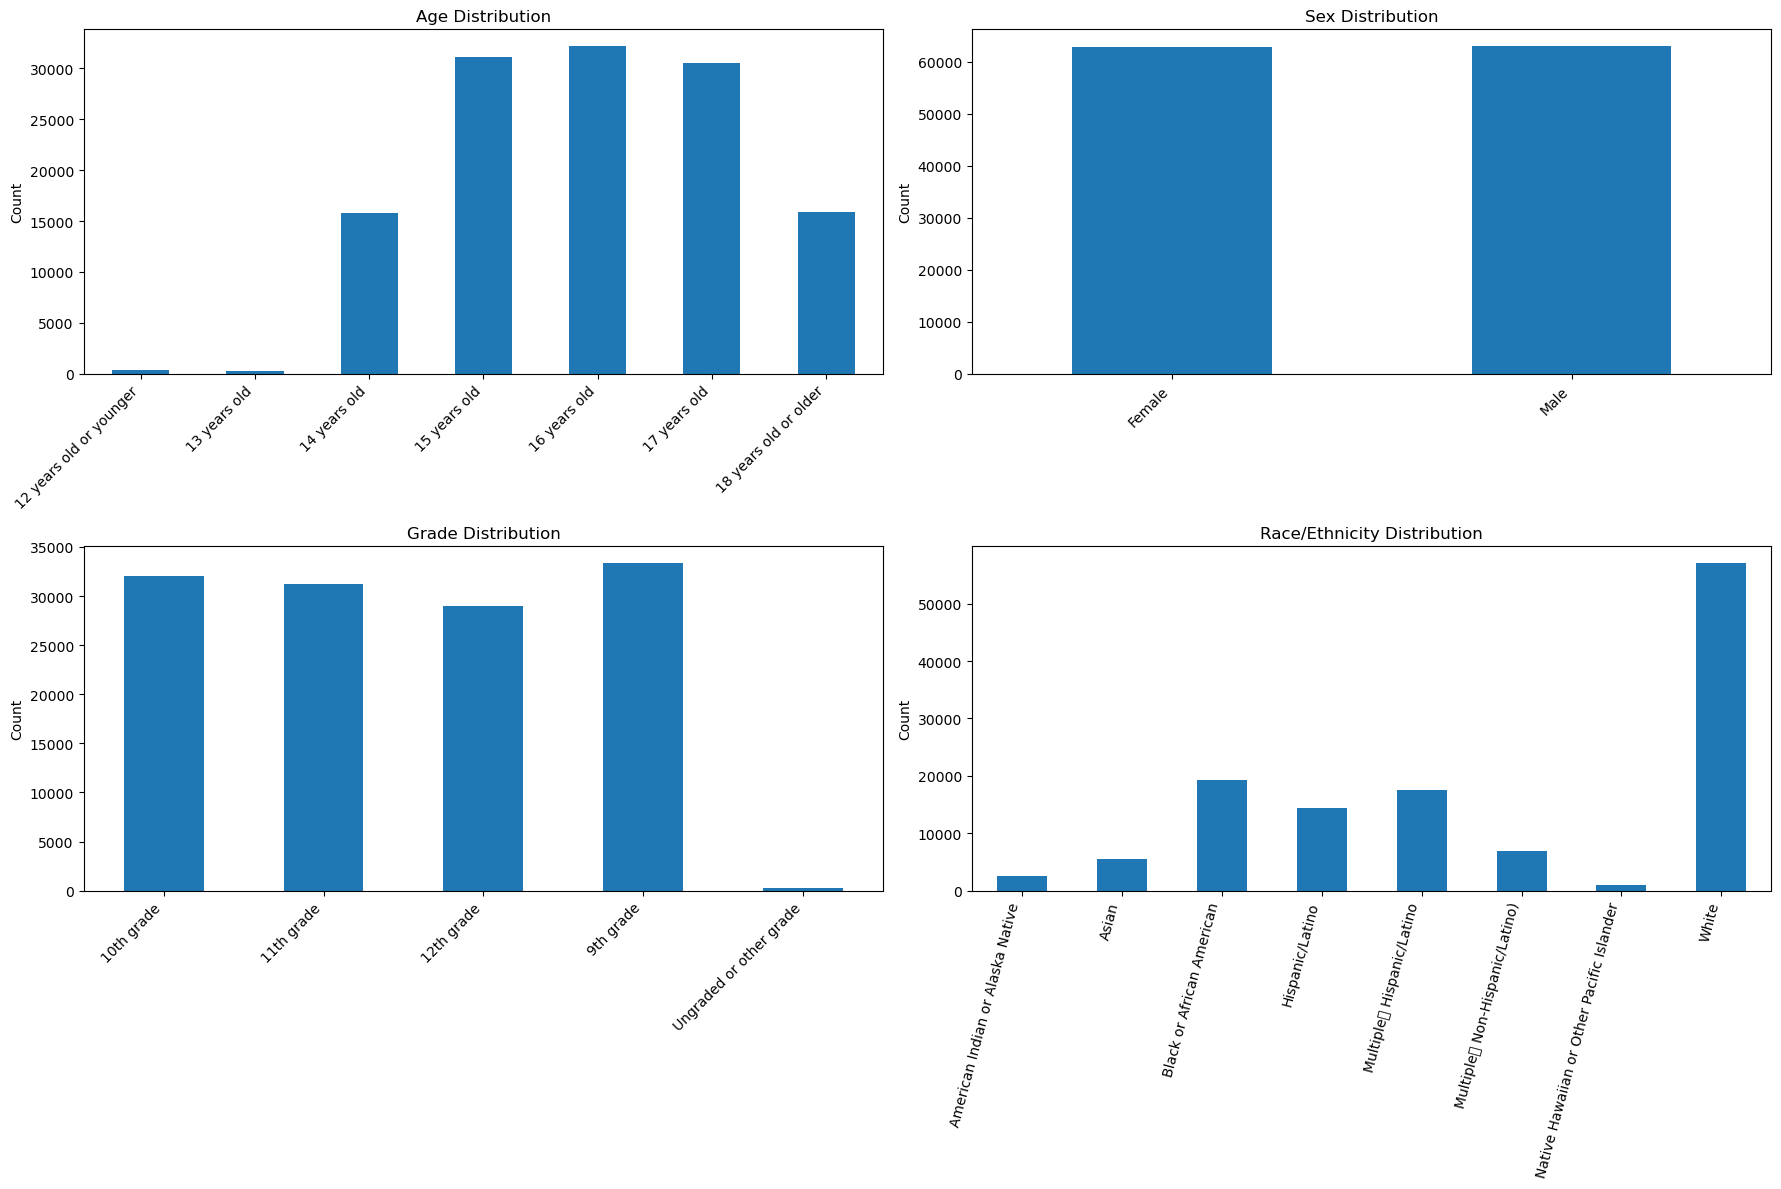

In [14]:

# -----------------------------------------------------------
# AGE
# -----------------------------------------------------------
age_lookup = pd.read_csv("02_Age.csv")
age_map = dict(zip(age_lookup["ID"], age_lookup["Description"]))

age_cols = [c for c in df.columns if "age" in c.lower() and "_label" not in c.lower()]
age_col = age_cols[0] if age_cols else None

if age_col:
    df["age_actual"] = df[age_col].map(age_map)

# -----------------------------------------------------------
# SEX
# -----------------------------------------------------------
sex_cols = [c for c in df.columns if "sex" in c.lower() and "_label" not in c.lower()]
sex_col = sex_cols[0] if sex_cols else None

sex_map = {1: "Female", 2: "Male"}

if sex_col:
    df["sex_actual"] = df[sex_col].map(sex_map)

# -----------------------------------------------------------
# GRADE
# -----------------------------------------------------------
grade_lookup = pd.read_csv("04_Grade.csv")
grade_map = dict(zip(grade_lookup["ID"], grade_lookup["Description"]))

grade_cols = [c for c in df.columns if "grade" in c.lower() and "_label" not in c.lower()]
grade_col = grade_cols[0] if grade_cols else None

if grade_col:
    df["grade_actual"] = df[grade_col].map(grade_map)

# -----------------------------------------------------------
# RACE (using 06_ethnicity)
# -----------------------------------------------------------
# Load lookup with safe encoding fallback
try:
    race_lookup = pd.read_csv("05_Race.csv", encoding="utf-8")
except UnicodeDecodeError:
    race_lookup = pd.read_csv("05_Race.csv", encoding="latin1")

# Create mapping
race_map = dict(zip(race_lookup["ID"], race_lookup["Description"]))

# Target column from standardized YRBS combined race/ethnicity variable
race_col = "06_ethnicity"

# Map codes → labels
if race_col in df.columns:
    df["race_actual"] = df[race_col].map(race_map)
else:
    print("ERROR: 06_ethnicity column not found in dataframe.")



# -----------------------------------------------------------
# PLOT ALL TOGETHER
# -----------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

plots = [
    ("Age Distribution", "age_actual"),
    ("Sex Distribution", "sex_actual"),
    ("Grade Distribution", "grade_actual"),
    ("Race/Ethnicity Distribution", "race_actual")
]

for ax, (title, col) in zip(axes, plots):
    if col in df.columns:
        df[col].value_counts().sort_index().plot(kind="bar", ax=ax)

        ax.set_title(title)
        ax.set_xlabel("")
        ax.set_ylabel("Count")

        # Guaranteed working rotation fix (explicitly updates tick labels)
        if col == "race_actual":
            ax.set_xticklabels(ax.get_xticklabels(), rotation=75, ha="right")
        else:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Demographic Overview of the YRBS data.  
The YRBS dataset offers a large, diverse sample of U.S. high school students, providing a broad and representative view of student characteristics across various demographic dimensions.

#### Age
The age distribution shows a typical spread among high school students. Most respondents are between 15 and 17 years old, with fewer students in the youngest and oldest age groups. This pattern aligns with the typical age range for high school students and indicates a good representation of students across grade levels. This pattern aligns with the modal high school age range and suggests adequate representation of students across grade levels.  

#### Sex
The sample is nearly evenly divided between female and male respondents. This near-parity supports balanced comparisons across sex-based analyses and reduces concerns about sex-related sampling bias.

#### Grade
Students in grades 9 through 12 are well represented in the dataset, with each grade contributing significant portions. The distribution is relatively balanced, with no single grade dominating the sample. A small number of respondents were classified as "ungraded or other," a pattern typical of YRBS datasets. A minimal number of respondents were classified as "ungraded or other grade," which is expected for YRBS datasets.

#### Race & Ethnicity
The dataset comprises students from a variety of racial and ethnic backgrounds. The largest group identifies as White, followed by significant representation from Black or African American, Hispanic/Latino, and Multiracial categories. Smaller yet important groups include Asian, American Indian or Alaska Native, and Native Hawaiian or Other Pacific Islander students. This diversity allows for the analysis of outcomes across different racial and ethnic subgroups; however, smaller categories should be interpreted with caution due to their lower sample sizes.



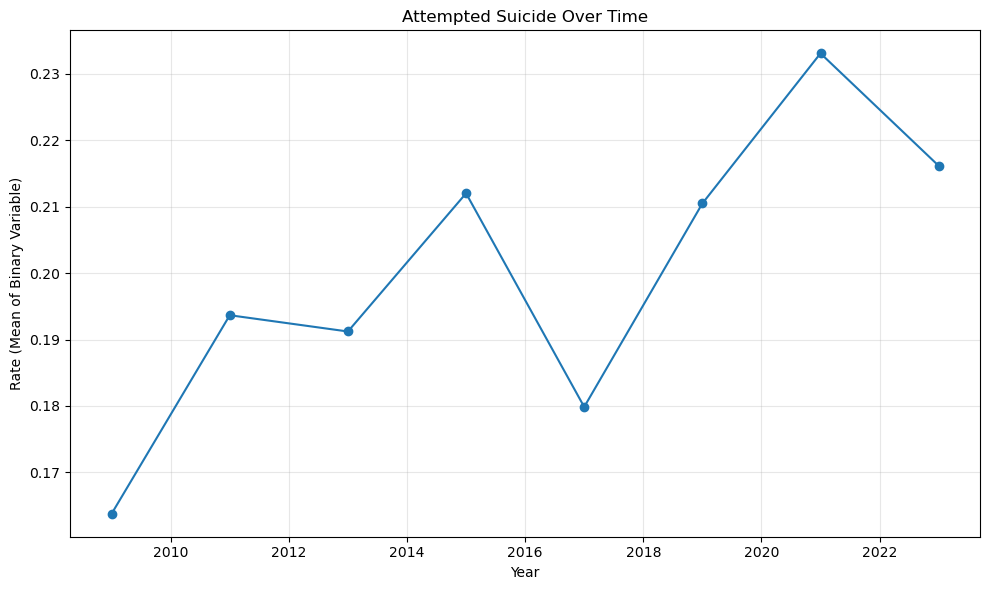

In [23]:
trend_vars = {
   
    "Attempted Suicide": "17_attempt_suicide_binary",
}

for label, col in trend_vars.items():
    if col in df.columns:
        yearly_mean = df.groupby("year")[col].mean()

        plt.figure(figsize=(10, 6))
        plt.plot(yearly_mean.index, yearly_mean.values, marker="o")
        plt.title(f"{label} Over Time")
        plt.xlabel("Year")
        plt.ylabel("Rate (Mean of Binary Variable)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

This chart shows the trend in self-reported suicide attempts from 2009 through 2023, using the binary version of the YRBS “attempted suicide” variable. While rates fluctuate from cycle to cycle, the overall pattern points toward a gradual increase over time, with noticeable peaks in the 2019 and 2021 surveys. These increases align with broader national concerns about adolescent mental health during the late 2010s and early 2020s. Although the pattern is not perfectly linear, the upward movement over the study period highlights why deeper analysis into contributing risk factors is warranted.

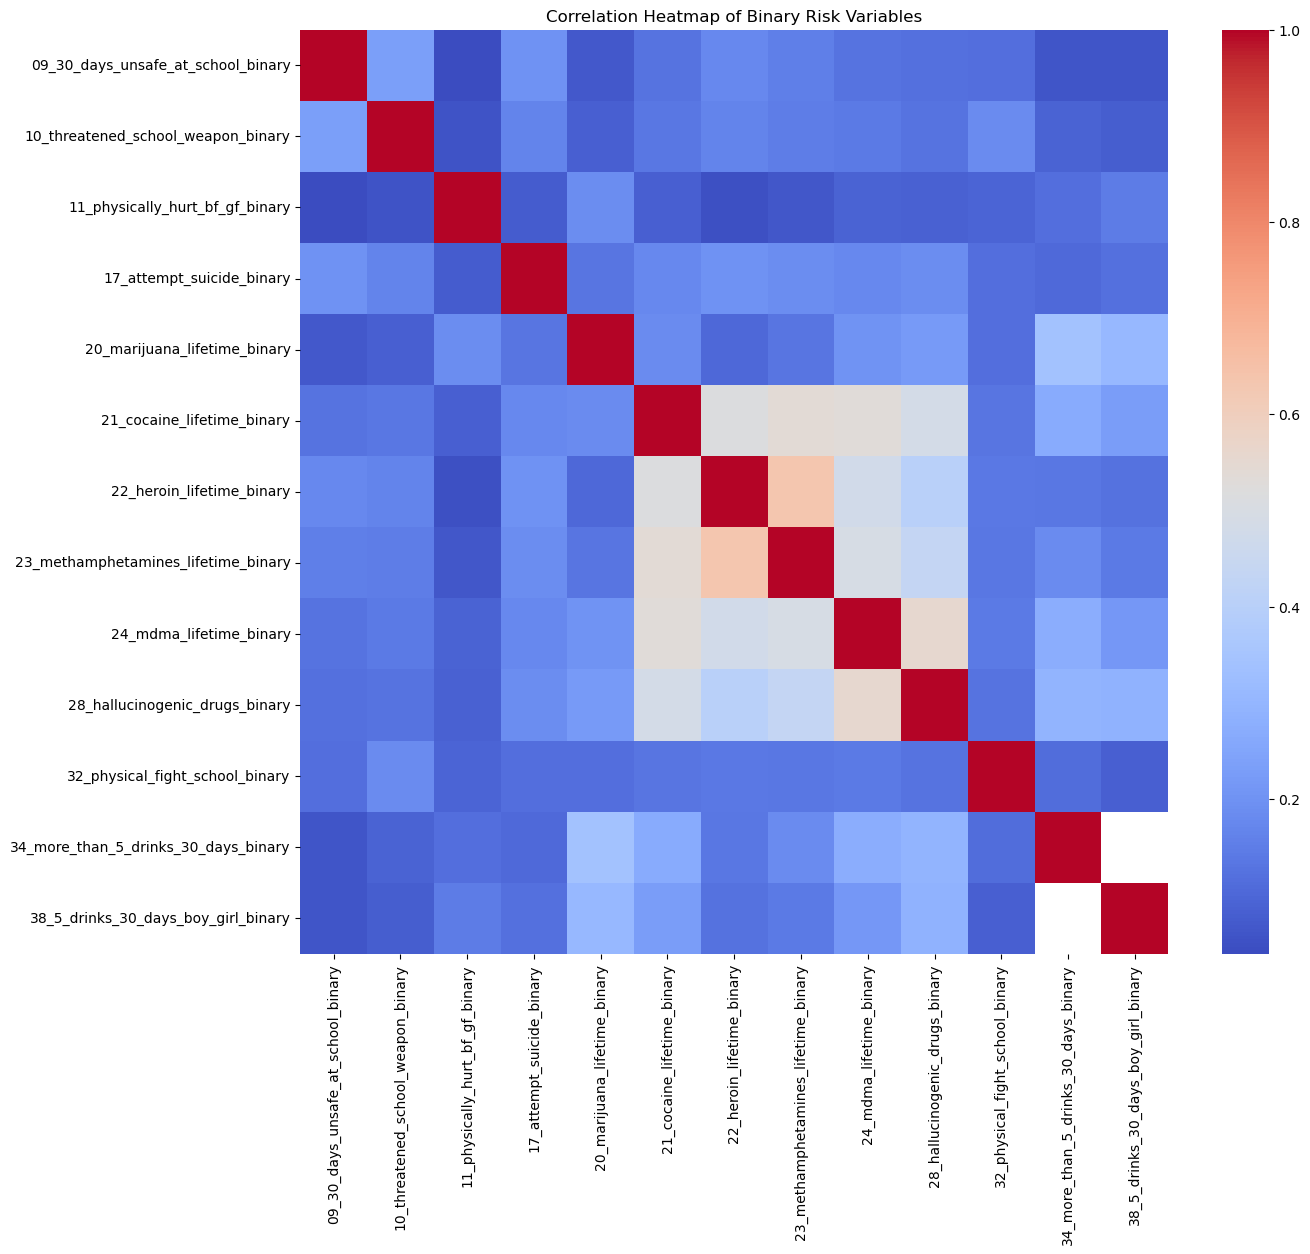

In [17]:
binary_cols = [c for c in df.columns if c.endswith("_binary")]
plt.figure(figsize=(14, 12))
sns.heatmap(df[binary_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Binary Risk Variables")
plt.show()

This heatmap shows how the binary risk-behavior variables relate to each other based on their pairwise correlations. Because each variable is coded as 0 or 1, the correlations here reflect how often two risk behaviors tend to occur together within the student population. Most of the cells are darker blue, indicating weak or low correlations, which means that most behaviors occur independently of one another. However, a few lighter patches appear among the substance-use variables (marijuana, cocaine, heroin, methamphetamines, and MDMA), suggesting that students who report one type of drug use are more likely to report others as well.

Overall, the heatmap provides a quick, high-level view of how risk behaviors overlap, helping identify which variables may carry shared information before running more formal predictive models.

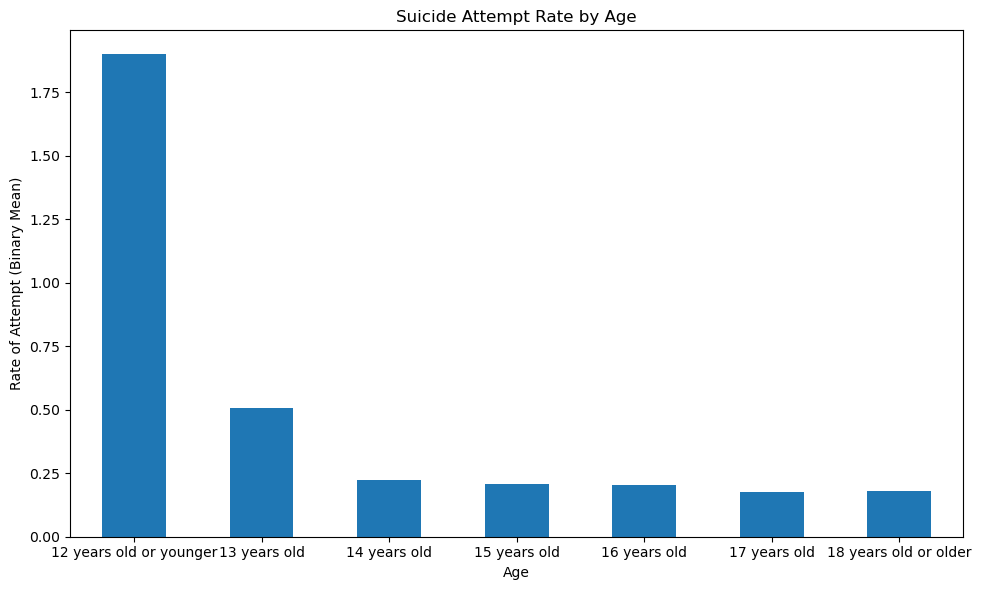

In [19]:
# Force-create binary suicide variables
yesno_vars = [
   # "14_sad_hopeless",
   # "15_consider_suicide",
   # "16_plan_suicide",
    "17_attempt_suicide"
]

for var in yesno_vars:
    if var in df.columns:
        df[f"{var}_binary"] = df[var].replace({
            1: 0,   # No
            2: 1,   # Yes
            7: pd.NA,
            8: pd.NA,
            9: pd.NA
        }).astype("Int64")
       # print(f"Created {var}_binary")
    else:
        print(f"Missing variable: {var}")

if "age_actual" in df.columns:

    age_attempt = (df.groupby("age_actual")["17_attempt_suicide_binary"]
                     .mean()
                     .dropna()
                     .sort_index())

    plt.figure(figsize=(10, 6))
    age_attempt.plot(kind="bar")
    plt.title("Suicide Attempt Rate by Age")
    plt.ylabel("Rate of Attempt (Binary Mean)")
    plt.xlabel("Age")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

This chart shows the average rate of self-reported suicide attempts by age group. Across most ages, the attempt rate falls within a fairly narrow range, indicating relatively consistent levels of reported attempts among students aged 14–18. The one noticeable exception is the “12 years old or younger” category, which appears much higher. This is likely driven by the small number of students in that group—when the sample size is very small, even a few reported attempts can disproportionately inflate the rate. Overall, aside from the outlier at the youngest age level, the suicide-attempt rate appears relatively stable across typical high-school ages.

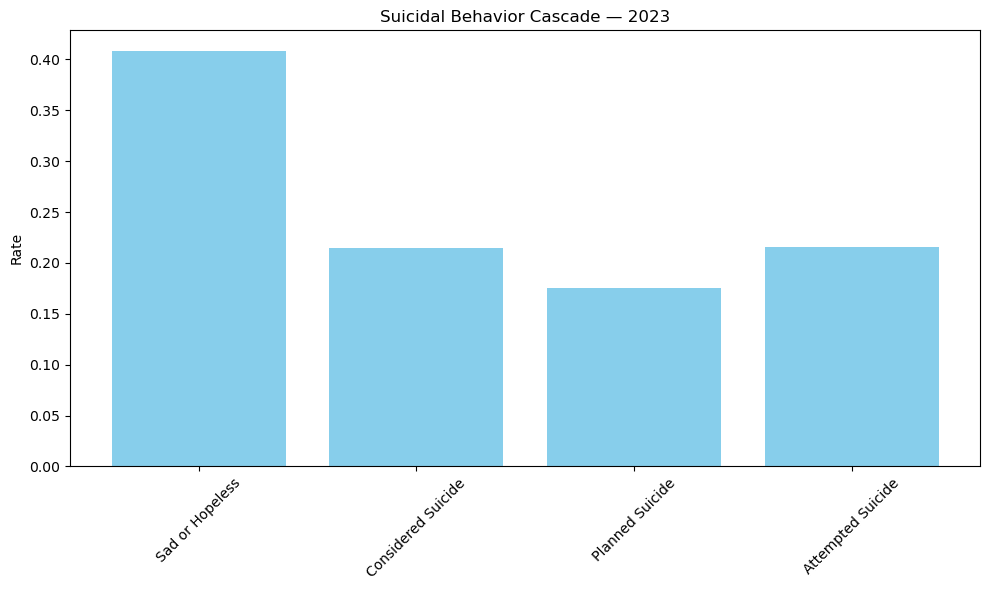

In [20]:
df_2023 = df[df["year"] == 2023]

cascade_vars = {
    "Sad or Hopeless": "14_sad_hopeless",
    "Considered Suicide": "15_consider_suicide",
    "Planned Suicide": "16_plan_suicide",
    "Attempted Suicide": "17_attempt_suicide_binary",
}

cascade_values = {
    label: df_2023[col].mean()
    for label, col in cascade_vars.items()
}

plt.figure(figsize=(10, 6))
plt.bar(cascade_values.keys(), cascade_values.values(), color="skyblue")
plt.title("Suicidal Behavior Cascade — 2023")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This chart summarizes the “suicidal behavior cascade” for the 2023 YRBS sample, illustrating how students experience varying levels of emotional distress and self-harm risk. The highest proportion of students reported feelings of sadness or hopelessness, indicating a widespread emotional strain. A smaller yet significant percentage seriously considered suicide, while an even fewer number reported making a plan. The rate of actual suicide attempts is lower still, which follows the expected pattern of decreasing prevalence as behaviors evolve from emotional symptoms to more severe actions. Together, these stages demonstrate how risk narrows as behaviors become more acute, emphasizing the importance of early intervention and prevention efforts.

In [22]:
# Indenpendent variables.

rows = []

for col in iv_list:
    if col in df.columns:
        count = df[col].sum()
        pct = df[col].mean() * 100
        rows.append([col, int(count), round(pct, 2)])
    else:
        rows.append([col, "Not found", "Not found"])

summary_df = pd.DataFrame(rows, columns=["Variable", "Count", "Percent"])
summary_df

,Variable,Count,Percent
0,11_physically_hurt_bf_gf_binary,91522,74.42
1,12_bullied_at_school_12_months,23198,18.72
2,13_forced_sexual_intercourse,9535,8.19
3,14_sad_hopeless,42351,33.82
4,15_consider_suicide,22851,18.28
5,16_plan_suicide,18287,14.90
6,09_30_days_unsafe_at_school_binary,9827,8.01
7,10_threatened_school_weapon_binary,8039,6.59
8,17_attempt_suicide_binary,21909,20.14
9,20_marijuana_lifetime_binary,31629,30.14


This table provides a summary of all the independent variables included in the analysis, along with their overall counts and prevalence rates across the combined dataset. Each variable represents a risk behavior or experience standardized as a binary indicator (1 = present, 0 = absent). These variables encompass various behavioral domains, such as bullying, violence, mental health, substance use, and high-risk behaviors, reflecting the proportion of students who reported each experience at least once during the specified timeframe. The percentages vary widely across the variables; some experiences, like feeling sad or hopeless, are relatively common, while others, such as heroin or methamphetamine use, are much less frequent. This table offers a comprehensive overview of the behavioral landscape captured in the YRBS data and serves as the foundation for the logistic regression models that follow.

In [ ]:
#### Logistic Regression Analysis